# KPrototypes

KMeans only works with numerical data. Since our dataset has a lot of categorical variables that we can exploit, we decided to try a variation of KMeans known as KPrototypes instead that offers support for both numerical and categorical data. 

KPrototypes is not available in `scikit-learn` but is available via the `kmodes` library.

**Setting up**

In [4]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

[04/23/23 20:00:42] INFO     Resolved project path as: d:\AI\Github\usg.                            ]8;id=315554;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=325598;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\ipython\__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/23/23 20:00:42] INFO     Kedro project usg                                                      ]8;id=369317;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=454506;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\ipython\__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=983660;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=362528;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\ipython\__init__.py#104\104]8;;\
                             'pipelines'                                                                           

In [5]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

In [10]:
X = catalog.load('train').set_index('appid')
X.describe().round(2)

[04/22/23 00:21:18] INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=519725;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=143765;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py#343\343]8;;\

,mac,linux,Multi-player,Steam Achievements,Steam Trading Cards,Indie,Action,Casual,Strategy,Simulation,...,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
count,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,...,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00
mean,0.30,0.19,0.15,0.52,0.29,0.72,0.44,0.38,0.19,0.19,...,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,0.46,0.39,0.35,0.50,0.45,0.45,0.50,0.48,0.40,0.39,...,1.97,1.22,1.07,0.94,0.91,0.75,0.67,0.63,0.48,0.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-3.35,-5.26,-4.01,-2.75,-3.01,-3.01,-2.82,-3.07,-1.95,-1.40
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.46,-0.89,-0.73,-0.74,-0.62,-0.46,-0.42,-0.42,-0.25,-0.16
50%,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,-0.38,-0.00,-0.09,-0.03,-0.02,-0.04,0.01,0.05,0.03,-0.01
75%,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,...,1.10,0.87,0.62,0.64,0.56,0.43,0.37,0.43,0.28,0.11
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,8.52,5.36,8.44,3.62,5.74,6.04,4.01,3.08,3.67,1.89


# Finding best number of clusters using elbow method

In [11]:
def cluster(k=1):
  model = KPrototypes(n_clusters = k, n_jobs = -2, random_state = 0)
  model.fit_predict(X, categorical=list(range(0, len(categorical))))
  return model

In [12]:
cost = []
for k in range(1, 100):
    try:
        log.info("Performing clustering for k=%d", k)
        model = cluster(k)
        cost.append(model.cost_)
        log.info("k=%d, cost=%d, n_iter=%d", k, model.cost_, model.n_iter_)
    except KeyboardInterrupt:
        break
cost

                    INFO     Performing clustering for k=1                                          ]8;id=12788;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=380771;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:21:31] INFO     k=1, cost=307018, n_iter=1                                             ]8;id=976599;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=473485;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=2                                          ]8;id=197669;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=471216;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:22:27] INFO     k=2, cost=232174, n_iter=12                                            ]8;id=977846;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=752821;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=3                                          ]8;id=686378;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=310391;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:23:54] INFO     k=3, cost=202812, n_iter=23                                            ]8;id=204191;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=799309;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=4                                          ]8;id=735186;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=107748;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:25:30] INFO     k=4, cost=187008, n_iter=18                                            ]8;id=875746;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=612221;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=5                                          ]8;id=475742;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=23546;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:27:30] INFO     k=5, cost=175946, n_iter=22                                            ]8;id=487598;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=301911;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=6                                          ]8;id=722422;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=717352;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:30:52] INFO     k=6, cost=167520, n_iter=19                                            ]8;id=956763;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=238343;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=7                                          ]8;id=508875;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=494127;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:34:19] INFO     k=7, cost=159616, n_iter=67                                            ]8;id=21825;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=630867;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=8                                          ]8;id=371241;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=314304;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:36:42] INFO     k=8, cost=152260, n_iter=22                                            ]8;id=18056;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=237551;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=9                                          ]8;id=552741;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=576733;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:39:05] INFO     k=9, cost=146706, n_iter=39                                            ]8;id=800258;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=442034;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=10                                         ]8;id=351996;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=510202;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:41:30] INFO     k=10, cost=142000, n_iter=27                                           ]8;id=427667;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=599632;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=11                                         ]8;id=36378;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=757608;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:44:45] INFO     k=11, cost=137803, n_iter=24                                           ]8;id=304212;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=204076;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=12                                         ]8;id=871206;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=937487;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:47:10] INFO     k=12, cost=134227, n_iter=36                                           ]8;id=488918;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=806747;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=13                                         ]8;id=838145;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=844962;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:50:33] INFO     k=13, cost=130877, n_iter=34                                           ]8;id=773964;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=295007;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=14                                         ]8;id=940655;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=821314;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:53:55] INFO     k=14, cost=127711, n_iter=34                                           ]8;id=448388;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=938169;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=15                                         ]8;id=101969;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=798126;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 00:57:57] INFO     k=15, cost=124771, n_iter=58                                           ]8;id=782968;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=801450;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=16                                         ]8;id=930330;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=175342;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:01:52] INFO     k=16, cost=122866, n_iter=32                                           ]8;id=480576;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=324804;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=17                                         ]8;id=907409;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=275026;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:05:27] INFO     k=17, cost=120944, n_iter=26                                           ]8;id=364691;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=783176;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=18                                         ]8;id=690382;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=20433;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:09:58] INFO     k=18, cost=118845, n_iter=39                                           ]8;id=209487;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=552564;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=19                                         ]8;id=354124;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=650632;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:14:17] INFO     k=19, cost=117177, n_iter=30                                           ]8;id=538282;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=847509;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=20                                         ]8;id=591364;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=930906;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:17:44] INFO     k=20, cost=116160, n_iter=39                                           ]8;id=907511;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=882105;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=21                                         ]8;id=854335;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=19792;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:21:40] INFO     k=21, cost=114458, n_iter=38                                           ]8;id=369152;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=905805;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=22                                         ]8;id=655924;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=667247;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:26:44] INFO     k=22, cost=113100, n_iter=46                                           ]8;id=904542;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=181727;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=23                                         ]8;id=313187;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=298676;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:32:18] INFO     k=23, cost=111838, n_iter=87                                           ]8;id=443788;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=420190;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=24                                         ]8;id=511688;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=191176;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:36:26] INFO     k=24, cost=110623, n_iter=52                                           ]8;id=217940;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=470619;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=25                                         ]8;id=46032;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=880252;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:41:45] INFO     k=25, cost=109643, n_iter=38                                           ]8;id=36622;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=164523;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=26                                         ]8;id=923285;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=593570;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:46:23] INFO     k=26, cost=108235, n_iter=65                                           ]8;id=74707;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=967612;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=27                                         ]8;id=797631;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=916643;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:52:32] INFO     k=27, cost=107278, n_iter=94                                           ]8;id=491033;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=335388;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=28                                         ]8;id=364180;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=455206;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 01:57:16] INFO     k=28, cost=105921, n_iter=54                                           ]8;id=964014;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=756342;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=29                                         ]8;id=408163;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=850899;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:04:00] INFO     k=29, cost=105157, n_iter=40                                           ]8;id=642824;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=303550;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=30                                         ]8;id=474451;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=599929;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:10:36] INFO     k=30, cost=104259, n_iter=37                                           ]8;id=903723;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=489333;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=31                                         ]8;id=931588;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=97207;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:15:58] INFO     k=31, cost=103287, n_iter=41                                           ]8;id=928792;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=720552;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=32                                         ]8;id=741223;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=350604;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:21:50] INFO     k=32, cost=102349, n_iter=51                                           ]8;id=433112;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=192982;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=33                                         ]8;id=407640;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=148971;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:28:36] INFO     k=33, cost=101516, n_iter=62                                           ]8;id=898121;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=929921;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=34                                         ]8;id=311431;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=968743;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:34:33] INFO     k=34, cost=100742, n_iter=29                                           ]8;id=316425;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=60855;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=35                                         ]8;id=963114;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=541843;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:40:02] INFO     k=35, cost=100018, n_iter=37                                           ]8;id=926950;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=17570;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=36                                         ]8;id=892945;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=876539;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:46:23] INFO     k=36, cost=99209, n_iter=56                                            ]8;id=485563;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=596724;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=37                                         ]8;id=864119;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=69181;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 02:53:53] INFO     k=37, cost=98520, n_iter=59                                            ]8;id=105278;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=770290;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=38                                         ]8;id=589595;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=593066;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:00:05] INFO     k=38, cost=97829, n_iter=74                                            ]8;id=872127;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=691672;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=39                                         ]8;id=393069;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=983119;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:06:41] INFO     k=39, cost=97138, n_iter=84                                            ]8;id=544780;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=333994;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=40                                         ]8;id=523888;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=812977;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:12:15] INFO     k=40, cost=96543, n_iter=67                                            ]8;id=358143;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=974838;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=41                                         ]8;id=711735;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=713263;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:19:11] INFO     k=41, cost=95804, n_iter=72                                            ]8;id=446291;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=409480;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=42                                         ]8;id=516722;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=963040;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:24:33] INFO     k=42, cost=94957, n_iter=54                                            ]8;id=292210;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=113795;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=43                                         ]8;id=71559;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=409107;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:31:01] INFO     k=43, cost=94730, n_iter=31                                            ]8;id=582811;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=212958;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=44                                         ]8;id=683454;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=482571;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:37:04] INFO     k=44, cost=94046, n_iter=54                                            ]8;id=382634;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=656437;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=45                                         ]8;id=431802;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=141744;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:45:25] INFO     k=45, cost=93581, n_iter=37                                            ]8;id=792270;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=467389;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=46                                         ]8;id=68872;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=223311;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:53:14] INFO     k=46, cost=92987, n_iter=31                                            ]8;id=36286;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=441471;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=47                                         ]8;id=915747;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=479974;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 03:59:25] INFO     k=47, cost=92517, n_iter=43                                            ]8;id=789611;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=182290;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=48                                         ]8;id=938029;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=246441;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 04:07:09] INFO     k=48, cost=92108, n_iter=42                                            ]8;id=377284;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=481919;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=49                                         ]8;id=429722;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=498698;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 04:15:03] INFO     k=49, cost=91545, n_iter=68                                            ]8;id=799315;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=639680;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=50                                         ]8;id=69211;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=350314;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 04:23:24] INFO     k=50, cost=90726, n_iter=47                                            ]8;id=781027;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=147592;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=51                                         ]8;id=747156;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=42778;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 04:31:30] INFO     k=51, cost=90666, n_iter=67                                            ]8;id=439254;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=96354;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=52                                         ]8;id=843122;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=24042;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 04:38:09] INFO     k=52, cost=90228, n_iter=60                                            ]8;id=829459;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=781613;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=53                                         ]8;id=498166;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=744072;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 04:45:51] INFO     k=53, cost=89582, n_iter=69                                            ]8;id=507975;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=971547;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=54                                         ]8;id=665578;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=380003;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 04:55:07] INFO     k=54, cost=89210, n_iter=100                                           ]8;id=179215;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=942677;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=55                                         ]8;id=295038;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=389888;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 05:03:57] INFO     k=55, cost=89029, n_iter=35                                            ]8;id=237454;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=70671;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=56                                         ]8;id=802810;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=260421;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 05:14:46] INFO     k=56, cost=88560, n_iter=51                                            ]8;id=697667;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=142408;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=57                                         ]8;id=62775;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=715035;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 05:25:23] INFO     k=57, cost=88103, n_iter=62                                            ]8;id=62007;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=750647;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=58                                         ]8;id=765529;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=809779;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 05:35:01] INFO     k=58, cost=87508, n_iter=33                                            ]8;id=948330;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=370957;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=59                                         ]8;id=362550;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=326151;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 05:43:54] INFO     k=59, cost=87230, n_iter=44                                            ]8;id=10254;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=687066;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=60                                         ]8;id=356559;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=917388;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 05:54:28] INFO     k=60, cost=86678, n_iter=55                                            ]8;id=534767;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=909223;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=61                                         ]8;id=155389;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=637331;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 06:03:38] INFO     k=61, cost=86493, n_iter=48                                            ]8;id=740996;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=713593;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=62                                         ]8;id=333118;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=227556;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 06:14:09] INFO     k=62, cost=86019, n_iter=52                                            ]8;id=385904;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=858818;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=63                                         ]8;id=954075;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=500724;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 06:25:16] INFO     k=63, cost=85663, n_iter=61                                            ]8;id=964210;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=822496;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=64                                         ]8;id=505752;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=22189;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 06:35:19] INFO     k=64, cost=85345, n_iter=33                                            ]8;id=175825;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=261323;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=65                                         ]8;id=758687;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=951017;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 06:47:06] INFO     k=65, cost=84965, n_iter=49                                            ]8;id=852001;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=30211;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=66                                         ]8;id=476901;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=935643;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 06:59:20] INFO     k=66, cost=84737, n_iter=73                                            ]8;id=228625;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=85434;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=67                                         ]8;id=40384;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=352685;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 07:11:26] INFO     k=67, cost=84230, n_iter=53                                            ]8;id=141583;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=811715;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=68                                         ]8;id=904637;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=9854;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 07:23:25] INFO     k=68, cost=84080, n_iter=66                                            ]8;id=699258;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=195430;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=69                                         ]8;id=57756;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=141461;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 07:35:37] INFO     k=69, cost=83630, n_iter=56                                            ]8;id=408016;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=961026;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=70                                         ]8;id=489028;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=630604;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 07:49:18] INFO     k=70, cost=83245, n_iter=53                                            ]8;id=882542;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=862344;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=71                                         ]8;id=812175;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=711762;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 08:03:18] INFO     k=71, cost=83150, n_iter=58                                            ]8;id=454202;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=460029;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=72                                         ]8;id=946741;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=885080;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 08:18:19] INFO     k=72, cost=82593, n_iter=90                                            ]8;id=65593;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=674170;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=73                                         ]8;id=342060;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=183539;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 08:32:12] INFO     k=73, cost=82334, n_iter=72                                            ]8;id=129012;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=16642;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=74                                         ]8;id=500847;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=678224;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 08:46:55] INFO     k=74, cost=82119, n_iter=48                                            ]8;id=974347;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=674715;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=75                                         ]8;id=197156;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=527252;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 09:02:08] INFO     k=75, cost=81940, n_iter=47                                            ]8;id=993332;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=738767;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=76                                         ]8;id=595621;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=326404;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 09:15:26] INFO     k=76, cost=81461, n_iter=57                                            ]8;id=573852;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=275487;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=77                                         ]8;id=358770;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=838804;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 09:30:32] INFO     k=77, cost=81348, n_iter=32                                            ]8;id=56062;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=286965;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=78                                         ]8;id=262602;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=958712;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 09:45:51] INFO     k=78, cost=80966, n_iter=38                                            ]8;id=247001;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=218577;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=79                                         ]8;id=40481;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=933664;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 10:02:26] INFO     k=79, cost=80926, n_iter=61                                            ]8;id=225487;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=435338;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=80                                         ]8;id=972506;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=182042;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 10:19:07] INFO     k=80, cost=80664, n_iter=45                                            ]8;id=199454;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=245002;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=81                                         ]8;id=181059;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=623710;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 10:34:55] INFO     k=81, cost=80416, n_iter=68                                            ]8;id=19978;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=355334;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=82                                         ]8;id=239192;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=518307;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 10:51:49] INFO     k=82, cost=79993, n_iter=43                                            ]8;id=349143;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=104633;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=83                                         ]8;id=583942;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=321141;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 11:08:27] INFO     k=83, cost=79730, n_iter=81                                            ]8;id=882137;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=900418;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=84                                         ]8;id=155248;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=781184;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

[04/22/23 11:27:07] INFO     k=84, cost=79588, n_iter=59                                            ]8;id=135865;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=191028;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=85                                         ]8;id=896905;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py\3115349066.py]8;;\:]8;id=247058;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\3115349066.py#4\4]8;;\

_RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\externals\loky\process_executor.py", line
428, in _process_worker
    r = call_item()
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\externals\loky\process_executor.py", line
275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\_parallel_backends.py", line 620, in 
__call__
    return self.func(*args, **kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kprototypes.py", line 410, in 
_k_prototypes_single
    raise ValueError(
ValueError: Clustering algorithm could not initialize. Consider assigning the initial clusters manually.
"""

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2 for k in range(1, 100):                                                                     │
│    3 │   try:                                                                                    │
│    4 │   │   log.info("Performing clustering for k=%d", k)                                       │
│ ❱  5 │   │   model = cluster(k)                                                                  │
│    6 │   │   cost.append(model.cost_)                                                            │
│    7 │   │   log.info("k=%d, cost=%d, n_iter=%d", k, model.cost_, model.n_iter_)                 │
│    8 │   except KeyboardInterrupt:                                                               │
│                                                                                                  │
│ in cluster:3                                                                                     │
│                                                                                                  │
│   1 def cluster(k=1):                                                                            │
│   2   model = KPrototypes(n_clusters = k, n_jobs = -2, random_state = 0)                         │
│ ❱ 3   model.fit_predict(X, categorical=list(range(0, len(categorical))))                         │
│   4   return model                                                                               │
│   5                                                                                              │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kmodes.py:154 in fit_predict   │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kprototypes.py:161 in fit      │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kprototypes.py:305 in          │
│ k_prototypes                                                                                     │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\parallel.py:1098 in __call__   │
│                                                                                                  

In [6]:
c_cost = [
307018,
232174,
202812,
187008,
175946,
167520,
159616,
152260,
146706,
142000,
137803,
134227,
130877,
127711,
124771,
122866,
120944,
118845,
117177,
116160,
114458,
113100,
111838,
110623,
109643,
108235,
107278,
105921,
105157,
104259,
103287,
102349,
101516,
100742,
100018,
99209,
98520,
97829,
97138,
96543,
95804,
94957,
94730,
94046,
93581,
92987,
92517,
92108,
91545,
90726,
90726,
90666,
90228,
89582,
89210,
89029,
88560,
88103,
87508,
87230,
86678,
86493,
86019,
85663,
85345,
84965,
84737,
84230,
84080,
93630,
83245,
83150,
82593,
82334,
82119,
81940,
81461,
81348,
80996,
80926,
80664,
80416,
79993,
79730,
79588]

**k=4, k=8, k=11 are good candidates for optimal number of clusters**
**We also noticed that when k=70, the cost is abnormally high compared to its neighbouring k-values which makes it a bad choice to use it as the optimumal number of clusters.**

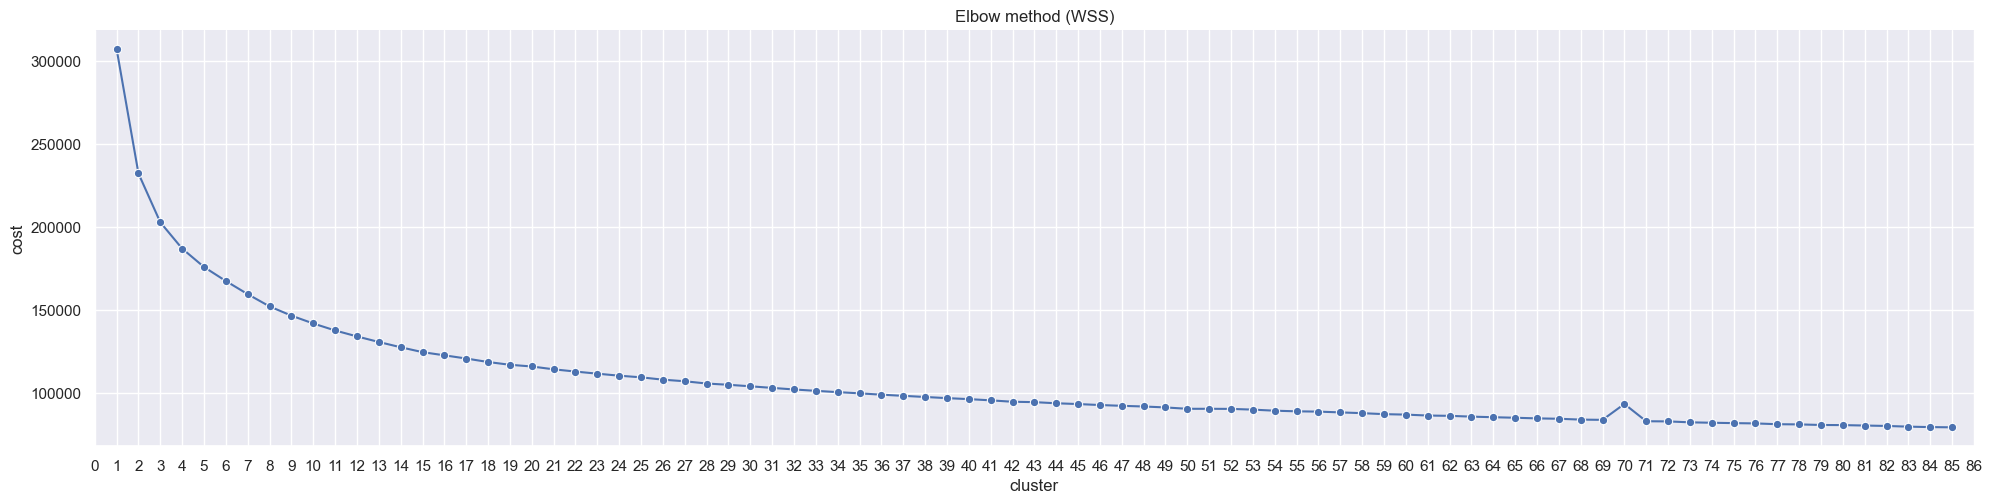

In [9]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'cluster': list(range(1, len(c_cost)+1)), 'cost': c_cost})
ax = sb.relplot(data=df_cost, x='cluster', y='cost', marker='o', kind='line', aspect=4).set(title='Elbow method (WSS)', xlim = (0,86))
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
ax

In [15]:
def fast_cluster(k=1):
  model = KPrototypes(n_clusters = k, n_jobs = -2, random_state = 2247, init='Huang', max_iter=30)
  model.fit_predict(X, categorical=list(range(0, len(categorical))))
  return model

In [16]:
silhouette = []

for k in range(2,100):
    try:
        log.info("Performing clustering for k=%d", k)
        model = fast_cluster(k)
        s = silhouette_score(X=X, labels=model.labels_)
        silhouette.append(s)
        log.info("k=%d, cost=%d, n_iter=%d, score=%.4f", k, model.cost_, model.n_iter_, s)
    except KeyboardInterrupt:
        break

silhouette

[04/22/23 11:44:47] INFO     Performing clustering for k=2                                          ]8;id=166879;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=382987;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:45:48] INFO     k=2, cost=232174, n_iter=14, score=0.2611                              ]8;id=62721;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=867018;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=3                                          ]8;id=115672;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=949292;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:46:59] INFO     k=3, cost=202812, n_iter=12, score=0.1587                              ]8;id=710408;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=449150;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=4                                          ]8;id=155256;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=988670;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:48:26] INFO     k=4, cost=187008, n_iter=23, score=0.1419                              ]8;id=680435;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=403837;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=5                                          ]8;id=631262;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=657130;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:50:07] INFO     k=5, cost=175946, n_iter=19, score=0.1413                              ]8;id=574884;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=442298;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=6                                          ]8;id=727855;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=812036;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:51:45] INFO     k=6, cost=167520, n_iter=19, score=0.1404                              ]8;id=977260;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=145356;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=7                                          ]8;id=684401;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=467582;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:53:39] INFO     k=7, cost=159615, n_iter=16, score=0.1239                              ]8;id=386864;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=274902;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=8                                          ]8;id=495344;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=267068;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:55:35] INFO     k=8, cost=152260, n_iter=17, score=0.1238                              ]8;id=649630;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=477561;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=9                                          ]8;id=993755;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=419673;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:57:37] INFO     k=9, cost=146706, n_iter=20, score=0.1193                              ]8;id=560837;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=734478;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=10                                         ]8;id=466756;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=280271;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 11:59:34] INFO     k=10, cost=142000, n_iter=30, score=0.1203                             ]8;id=809390;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=149247;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=11                                         ]8;id=861560;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=338429;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:01:32] INFO     k=11, cost=137805, n_iter=28, score=0.1196                             ]8;id=238920;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=511580;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=12                                         ]8;id=84674;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=446821;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:03:42] INFO     k=12, cost=134230, n_iter=30, score=0.1172                             ]8;id=448211;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=209309;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=13                                         ]8;id=681150;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=25134;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:05:51] INFO     k=13, cost=130877, n_iter=30, score=0.1188                             ]8;id=788107;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=537722;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=14                                         ]8;id=248535;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=892507;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:08:05] INFO     k=14, cost=127700, n_iter=30, score=0.1194                             ]8;id=857456;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=985818;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=15                                         ]8;id=941687;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=626128;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:10:18] INFO     k=15, cost=125657, n_iter=22, score=0.1102                             ]8;id=607513;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=928624;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=16                                         ]8;id=104246;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=708470;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:12:31] INFO     k=16, cost=122698, n_iter=30, score=0.1130                             ]8;id=863697;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=98899;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=17                                         ]8;id=572000;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=549650;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:14:55] INFO     k=17, cost=120705, n_iter=30, score=0.1169                             ]8;id=659317;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=929779;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=18                                         ]8;id=345106;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=696359;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:17:06] INFO     k=18, cost=118739, n_iter=30, score=0.1170                             ]8;id=446068;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=149004;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=19                                         ]8;id=257686;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=668159;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:19:30] INFO     k=19, cost=117381, n_iter=30, score=0.1150                             ]8;id=178142;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=578217;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=20                                         ]8;id=304018;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=448134;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:21:56] INFO     k=20, cost=116014, n_iter=30, score=0.1048                             ]8;id=191423;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=528861;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=21                                         ]8;id=575878;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=184706;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:24:23] INFO     k=21, cost=114325, n_iter=30, score=0.1062                             ]8;id=526992;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=624897;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=22                                         ]8;id=156317;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=657691;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:26:52] INFO     k=22, cost=113310, n_iter=30, score=0.1034                             ]8;id=124473;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=77336;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=23                                         ]8;id=445418;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=646427;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:29:32] INFO     k=23, cost=111679, n_iter=30, score=0.0989                             ]8;id=591387;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=417914;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=24                                         ]8;id=435537;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=964733;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:32:07] INFO     k=24, cost=110606, n_iter=30, score=0.1070                             ]8;id=903465;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=201266;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=25                                         ]8;id=346944;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=251699;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:34:45] INFO     k=25, cost=109405, n_iter=30, score=0.1004                             ]8;id=592673;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=386891;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=26                                         ]8;id=323608;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=846436;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:37:05] INFO     k=26, cost=108560, n_iter=18, score=0.0955                             ]8;id=683048;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=28693;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=27                                         ]8;id=719476;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=747325;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:39:45] INFO     k=27, cost=107529, n_iter=30, score=0.0981                             ]8;id=24237;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=328510;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=28                                         ]8;id=451215;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=954415;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:42:34] INFO     k=28, cost=106140, n_iter=30, score=0.0974                             ]8;id=230190;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=367913;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=29                                         ]8;id=683838;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=285070;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:45:16] INFO     k=29, cost=105422, n_iter=30, score=0.0959                             ]8;id=858659;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=177674;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=30                                         ]8;id=125034;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=228316;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:47:57] INFO     k=30, cost=104131, n_iter=30, score=0.0949                             ]8;id=310215;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=746009;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=31                                         ]8;id=276191;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=644159;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:50:42] INFO     k=31, cost=103330, n_iter=30, score=0.0942                             ]8;id=535219;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=197950;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=32                                         ]8;id=817404;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=806802;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:53:35] INFO     k=32, cost=102494, n_iter=30, score=0.0948                             ]8;id=626897;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=417753;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=33                                         ]8;id=228675;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=563067;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:56:33] INFO     k=33, cost=101689, n_iter=30, score=0.0939                             ]8;id=734199;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=444601;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=34                                         ]8;id=328882;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=58731;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 12:59:30] INFO     k=34, cost=100765, n_iter=30, score=0.0943                             ]8;id=403276;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=951941;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=35                                         ]8;id=65872;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=259020;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:02:31] INFO     k=35, cost=100139, n_iter=30, score=0.0922                             ]8;id=401297;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=453613;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=36                                         ]8;id=729066;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=234372;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:05:27] INFO     k=36, cost=99200, n_iter=30, score=0.0933                              ]8;id=463266;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=511446;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=37                                         ]8;id=860944;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=424916;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:08:29] INFO     k=37, cost=98204, n_iter=30, score=0.0925                              ]8;id=67631;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=247758;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=38                                         ]8;id=952161;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=667187;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:11:37] INFO     k=38, cost=97878, n_iter=30, score=0.0906                              ]8;id=998140;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=468299;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=39                                         ]8;id=801454;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=782976;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:14:45] INFO     k=39, cost=97237, n_iter=24, score=0.0901                              ]8;id=461234;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=611761;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=40                                         ]8;id=573461;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=359991;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:17:50] INFO     k=40, cost=96391, n_iter=30, score=0.0919                              ]8;id=561308;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=526166;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=41                                         ]8;id=162071;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=573189;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:21:02] INFO     k=41, cost=95826, n_iter=30, score=0.0901                              ]8;id=97856;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=228095;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=42                                         ]8;id=236305;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=392457;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:23:51] INFO     k=42, cost=95410, n_iter=30, score=0.0921                              ]8;id=587660;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=869668;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=43                                         ]8;id=701532;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=428772;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:27:09] INFO     k=43, cost=94641, n_iter=30, score=0.0885                              ]8;id=972265;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=150903;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=44                                         ]8;id=39607;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=838847;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:30:18] INFO     k=44, cost=94095, n_iter=30, score=0.0920                              ]8;id=576195;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=942571;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=45                                         ]8;id=192391;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=996526;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:33:28] INFO     k=45, cost=93709, n_iter=30, score=0.0891                              ]8;id=385304;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=825266;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=46                                         ]8;id=422702;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=308768;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:37:08] INFO     k=46, cost=92987, n_iter=30, score=0.0904                              ]8;id=952011;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=368790;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=47                                         ]8;id=866149;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=445377;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:40:40] INFO     k=47, cost=92678, n_iter=30, score=0.0880                              ]8;id=516526;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=493067;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=48                                         ]8;id=72944;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=595546;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:44:14] INFO     k=48, cost=91868, n_iter=30, score=0.0888                              ]8;id=998569;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=409788;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=49                                         ]8;id=837653;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=466723;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:47:29] INFO     k=49, cost=91566, n_iter=30, score=0.0876                              ]8;id=940425;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=978007;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=50                                         ]8;id=199454;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=428525;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:50:58] INFO     k=50, cost=91033, n_iter=30, score=0.0876                              ]8;id=358515;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=868607;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=51                                         ]8;id=541424;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=804469;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:54:40] INFO     k=51, cost=90724, n_iter=30, score=0.0871                              ]8;id=23012;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=45097;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=52                                         ]8;id=327868;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=630114;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 13:58:08] INFO     k=52, cost=90117, n_iter=30, score=0.0856                              ]8;id=309181;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=439554;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=53                                         ]8;id=713535;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=676561;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:01:44] INFO     k=53, cost=89751, n_iter=30, score=0.0861                              ]8;id=406856;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=192150;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=54                                         ]8;id=176247;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=741432;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:05:47] INFO     k=54, cost=89336, n_iter=30, score=0.0847                              ]8;id=354863;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=251120;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=55                                         ]8;id=223843;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=475313;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:10:04] INFO     k=55, cost=88737, n_iter=30, score=0.0859                              ]8;id=118496;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=88416;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=56                                         ]8;id=260994;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=711459;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:13:58] INFO     k=56, cost=88365, n_iter=30, score=0.0848                              ]8;id=990664;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=79762;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=57                                         ]8;id=17898;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=777916;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:18:05] INFO     k=57, cost=87967, n_iter=30, score=0.0860                              ]8;id=218295;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=889164;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=58                                         ]8;id=720643;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=950443;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:21:40] INFO     k=58, cost=87554, n_iter=30, score=0.0838                              ]8;id=968738;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=416544;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=59                                         ]8;id=452710;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=614662;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:25:37] INFO     k=59, cost=87215, n_iter=30, score=0.0859                              ]8;id=813077;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=742829;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=60                                         ]8;id=329246;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=845862;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:29:36] INFO     k=60, cost=86985, n_iter=30, score=0.0829                              ]8;id=615274;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=603339;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=61                                         ]8;id=881481;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=910378;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:34:09] INFO     k=61, cost=86458, n_iter=30, score=0.0840                              ]8;id=630144;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=500064;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=62                                         ]8;id=629078;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=608709;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:38:06] INFO     k=62, cost=85897, n_iter=30, score=0.0835                              ]8;id=723489;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=947131;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=63                                         ]8;id=158690;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=603263;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:42:01] INFO     k=63, cost=85555, n_iter=30, score=0.0831                              ]8;id=254563;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=754097;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=64                                         ]8;id=440894;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=950250;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:46:34] INFO     k=64, cost=85444, n_iter=30, score=0.0807                              ]8;id=470059;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=520009;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=65                                         ]8;id=262247;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=996733;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:51:16] INFO     k=65, cost=84818, n_iter=30, score=0.0830                              ]8;id=468339;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=193324;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=66                                         ]8;id=858270;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=460151;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:55:22] INFO     k=66, cost=84736, n_iter=30, score=0.0823                              ]8;id=356074;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=92948;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=67                                         ]8;id=62757;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=30894;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 14:59:53] INFO     k=67, cost=84343, n_iter=30, score=0.0826                              ]8;id=782853;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=330708;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=68                                         ]8;id=542917;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=804714;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:04:54] INFO     k=68, cost=84169, n_iter=30, score=0.0830                              ]8;id=455403;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=422533;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=69                                         ]8;id=169429;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=267489;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:09:38] INFO     k=69, cost=83566, n_iter=30, score=0.0809                              ]8;id=463184;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=763295;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=70                                         ]8;id=89182;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=773919;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:14:23] INFO     k=70, cost=83406, n_iter=30, score=0.0816                              ]8;id=69721;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=947313;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=71                                         ]8;id=291104;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=231338;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:19:09] INFO     k=71, cost=83060, n_iter=30, score=0.0817                              ]8;id=241971;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=399686;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=72                                         ]8;id=102744;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=922750;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:23:43] INFO     k=72, cost=82933, n_iter=30, score=0.0801                              ]8;id=494586;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=554293;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=73                                         ]8;id=843076;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=728404;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:28:11] INFO     k=73, cost=82405, n_iter=30, score=0.0822                              ]8;id=130814;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=339639;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=74                                         ]8;id=479193;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=874256;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:32:54] INFO     k=74, cost=82094, n_iter=30, score=0.0797                              ]8;id=855738;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=220819;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=75                                         ]8;id=517261;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=956104;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:37:53] INFO     k=75, cost=82079, n_iter=30, score=0.0809                              ]8;id=115527;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=8381;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=76                                         ]8;id=505133;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=804217;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:43:29] INFO     k=76, cost=81478, n_iter=30, score=0.0828                              ]8;id=257778;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=551937;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=77                                         ]8;id=859042;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=505632;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:48:55] INFO     k=77, cost=81340, n_iter=30, score=0.0816                              ]8;id=529777;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=119214;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=78                                         ]8;id=96318;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=589399;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

[04/22/23 15:53:24] INFO     k=78, cost=81055, n_iter=30, score=0.0806                              ]8;id=379886;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=692430;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#9\9]8;;\

                    INFO     Performing clustering for k=79                                         ]8;id=920315;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py\1992391408.py]8;;\:]8;id=381777;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\1992391408.py#5\5]8;;\

_RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\externals\loky\process_executor.py", line
428, in _process_worker
    r = call_item()
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\externals\loky\process_executor.py", line
275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\_parallel_backends.py", line 620, in 
__call__
    return self.func(*args, **kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kprototypes.py", line 410, in 
_k_prototypes_single
    raise ValueError(
ValueError: Clustering algorithm could not initialize. Consider assigning the initial clusters manually.
"""

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│    3 for k in range(2,100):                                                                      │
│    4 │   try:                                                                                    │
│    5 │   │   log.info("Performing clustering for k=%d", k)                                       │
│ ❱  6 │   │   model = fast_cluster(k)                                                             │
│    7 │   │   s = silhouette_score(X=X, labels=model.labels_)                                     │
│    8 │   │   silhouette.append(s)                                                                │
│    9 │   │   log.info("k=%d, cost=%d, n_iter=%d, score=%.4f", k, model.cost_, model.n_iter_,     │
│                                                                                                  │
│ in fast_cluster:3                                                                                │
│                                                                                                  │
│   1 def fast_cluster(k=1):                                                                       │
│   2   model = KPrototypes(n_clusters = k, n_jobs = -2, random_state = 2247, init='Huang', ma     │
│ ❱ 3   model.fit_predict(X, categorical=list(range(0, len(categorical))))                         │
│   4   return model                                                                               │
│   5                                                                                              │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kmodes.py:154 in fit_predict   │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kprototypes.py:161 in fit      │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kmodes\kprototypes.py:305 in          │
│ k_prototypes                                                                                     │
│                                                                                                  │
│ c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\joblib\parallel.py:1098 in __call__   │
│                                                                                                  

In [10]:
scores = [0.2611,
0.1587,
0.1419,
0.1413,
0.1404,
0.1239,
0.1238,
0.1193,
0.1203,
0.1196,
0.1172,
0.1188,
0.1194,
0.1102,
0.1130,
0.1169,
0.1170,
0.1150,
0.1048,
0.1062,
0.1034,
0.0989,
0.1070,
0.1004,
0.0955,
0.0981,
0.0974,
0.0959,
0.0949,
0.0942,
0.0948,
0.0939,
0.0943,
0.0922,
0.0933,
0.0925,
0.0906,
0.0901,
0.0919,
0.0901,
0.0921,
0.0885,
0.0920,
0.0891,
0.0904,
0.0880,
0.0888,
0.0876,
0.0876,
0.0871,
0.0856,
0.0861,
0.0847,
0.0859,
0.0848,
0.0860,
0.0838,
0.0859,
0.0829,
0.0840,
0.0835,
0.0831,
0.0807,
0.0830,
0.0823,
0.0826,
0.0830,
0.0809,
0.0816,
0.0817,
0.0801,
0.0822,
0.0797,
0.0809,
0.0828,
0.0816,
0.0806]

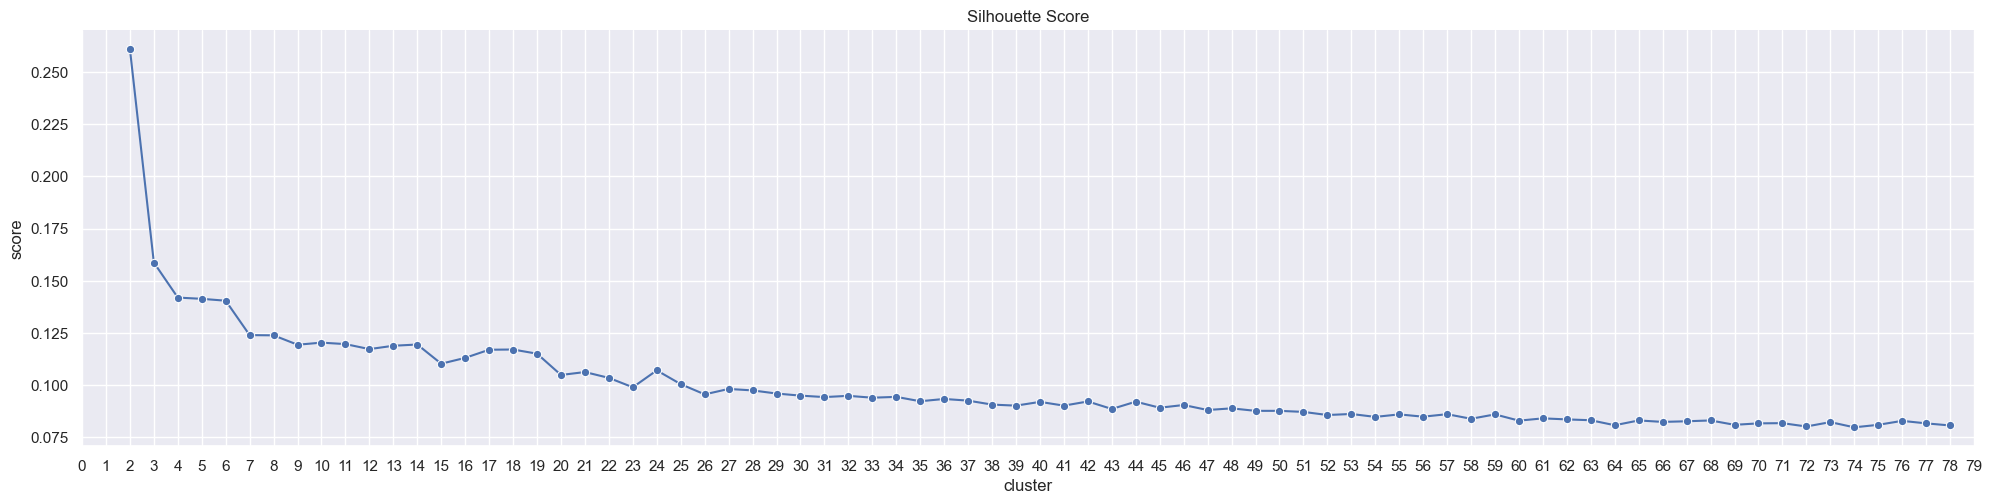

In [13]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'cluster': list(range(2, len(scores)+2)), 'score': scores})
ax = sb.relplot(data=df_cost, x='cluster', y='score', marker='o', kind='line', aspect=4).set(title='Silhouette Score', xlim = (0,79))
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
ax

# Summary

We select `k=4` because it has the best silhouette score (ignoring 2 and 3). One reason for the low silhouette scores could be due to the fact that the statistics for steam games such as `positive_ratings`, `median_playtime`, `achievements` are not innate modifiers of the games. They could be influenced by external factors such as media coverage, country bans, awards, or even launch of competitors (e.g. Epic Games Store) etc.

Things that could be more organic would include `budget` allocated for the game, `development team size`, `duration of development` etc.

We can observe that there is a unusual dip in the silhouette score of `k=15 and k=16` wihch means that these values are poor choices to be used for optimal k-value.

There is also a huge spike at `k=24` which could be investigated as well.

In [19]:
for k in [4,24]:
    try:
        log.info("Performing clustering for k=%d", k)
        model = cluster(k)
        log.info("k=%d, cost=%d, n_iter=%d", k, model.cost_, model.n_iter_)
        catalog.save(f'model@kprototypes@{k}', model)
        catalog.save(f'labels@kprototypes@{k}', pd.Series(model.labels_, name='cluster'))
    except KeyboardInterrupt:
        break

[04/22/23 15:58:56] INFO     Performing clustering for k=4                                          ]8;id=373089;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py\2598878376.py]8;;\:]8;id=748773;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py#3\3]8;;\

[04/22/23 16:00:27] INFO     k=4, cost=187008, n_iter=18                                            ]8;id=539908;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py\2598878376.py]8;;\:]8;id=965156;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py#5\5]8;;\

                    INFO     Saving data to 'model@kprototypes@4' (PickleDataSet)...            ]8;id=643227;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=692773;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py#382\382]8;;\

                    INFO     Saving data to 'labels@kprototypes@4' (CSVDataSet)...              ]8;id=300193;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=977872;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py#382\382]8;;\

                    INFO     Performing clustering for k=24                                         ]8;id=397779;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py\2598878376.py]8;;\:]8;id=163211;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py#3\3]8;;\

[04/22/23 16:04:29] INFO     k=24, cost=110623, n_iter=52                                           ]8;id=993250;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py\2598878376.py]8;;\:]8;id=914297;file://C:\Users\hao_l\AppData\Local\Temp\ipykernel_10528\2598878376.py#5\5]8;;\

                    INFO     Saving data to 'model@kprototypes@24' (PickleDataSet)...           ]8;id=675058;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=724855;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py#382\382]8;;\

                    INFO     Saving data to 'labels@kprototypes@24' (CSVDataSet)...             ]8;id=591308;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=805;file://c:\Users\hao_l\.conda\envs\sc1015project\lib\site-packages\kedro\io\data_catalog.py#382\382]8;;\